Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

Data Preparation

In [99]:
stock_data = yf.download("AAPL MSFT AMZN", start="2018-10-01", end="2023-09-30")
stock_data.to_csv('stock_data.csv')
print(stock_data)

[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close              \
                  AAPL        AMZN        MSFT        AAPL        AMZN   
Date                                                                     
2018-10-01   54.342045  100.218002  109.310699   56.814999  100.218002   
2018-10-02   54.825066   98.565498  108.875771   57.320000   98.565498   
2018-10-03   55.492210   97.638000  108.894669   58.017502   97.638000   
2018-10-04   54.516605   95.471001  106.644356   56.997501   95.471001   
2018-10-05   53.631863   94.482498  106.020309   56.072498   94.482498   
...                ...         ...         ...         ...         ...   
2023-09-25  175.848328  131.270004  316.896820  176.080002  131.270004   
2023-09-26  171.733749  125.980003  311.507751  171.960007  125.980003   
2023-09-27  170.205750  125.980003  312.156433  170.429993  125.980003   
2023-09-28  170.465424  125.980003  313.004

In [100]:
#Check for missing values
print(stock_data.isnull().sum())

Adj Close  AAPL    0
           AMZN    0
           MSFT    0
Close      AAPL    0
           AMZN    0
           MSFT    0
High       AAPL    0
           AMZN    0
           MSFT    0
Low        AAPL    0
           AMZN    0
           MSFT    0
Open       AAPL    0
           AMZN    0
           MSFT    0
Volume     AAPL    0
           AMZN    0
           MSFT    0
dtype: int64


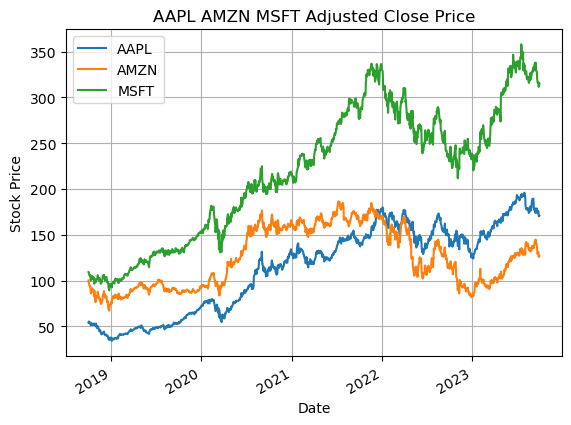

In [101]:
sorted_data = stock_data.sort_values(by="Date", ascending=False)
stock_data['Adj Close'].plot(title=f"AAPL AMZN MSFT Adjusted Close Price", grid=True)
plt.ylabel('Stock Price')
plt.show()

In [102]:
stock_data_adj = stock_data[['Adj Close']]
stock_data_arr = stock_data_adj.values
stock_data_arr

array([[ 54.34204483, 100.21800232, 109.31069946],
       [ 54.82506561,  98.56549835, 108.87577057],
       [ 55.49221039,  97.63800049, 108.89466858],
       ...,
       [170.20574951, 125.98000336, 312.15643311],
       [170.46542358, 125.98000336, 313.00473022],
       [170.98474121, 127.12000275, 315.11044312]])

## LSTM Model Training

In [103]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data_arr)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQUENCE_LENGTH = 5  # Using last week data to predict the next day
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

train_size= int(0.8 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train.shape

(1002, 5, 3)

LSTM Model Structure

In [104]:
def build_lstm(epochs=25, batch_size=32):
    """
    Builds, compiles, and fits the LSTM baseline model.
    """
    num_timesteps, num_features, num_outputs = 5, 3, 3
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(num_timesteps, num_features)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_outputs))

    ## compile the baseline model
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

    ## train and fit the model
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        verbose=1,
                        callbacks=callbacks)

    return model, history

In [105]:
model, history = build_lstm()

Epoch 1/25
32/32 [==============================] - 1s 22ms/step - loss: 0.0654 - mae: 0.1785 - mape: 151481.0469 - val_loss: 0.0567 - val_mae: 0.2302 - val_mape: 45.2833
Epoch 2/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0061 - mae: 0.0612 - mape: 98491.8984 - val_loss: 0.0271 - val_mae: 0.1533 - val_mape: 35.0534
Epoch 3/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mae: 0.0363 - mape: 48242.4570 - val_loss: 0.0027 - val_mae: 0.0426 - val_mape: 9.4666
Epoch 4/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - mae: 0.0264 - mape: 45847.6328 - val_loss: 0.0022 - val_mae: 0.0382 - val_mape: 8.2060
Epoch 5/25
32/32 [==============================] - 0s 8ms/step - loss: 0.0011 - mae: 0.0252 - mape: 44810.3594 - val_loss: 0.0021 - val_mae: 0.0376 - val_mape: 7.6686
Epoch 6/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0010 - mae: 0.0241 - mape: 41359.6211 - val_loss: 0.0019 - val_mae: 0.0358 - val_m

In [106]:
## Predict test set
predicted_stock_price = model.predict(X_test)
actual_predictions = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 0s 2ms/step


In [107]:
stock_data.index[train_size+SEQUENCE_LENGTH]

Timestamp('2022-09-30 00:00:00')

Visualization

(1007, 3)


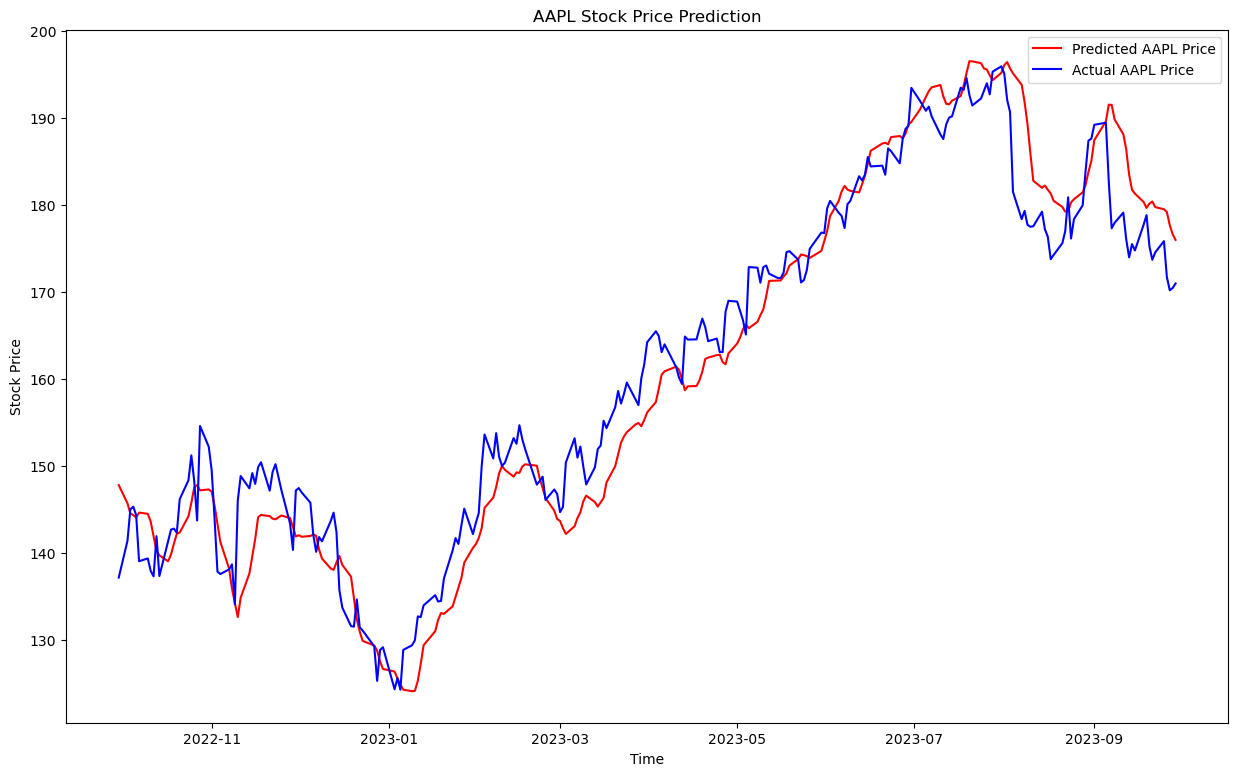

In [108]:
train = stock_data_adj[:train_size+SEQUENCE_LENGTH]
test = stock_data_adj[train_size+SEQUENCE_LENGTH:]

print(train.shape)

plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 0], color='red', label='Predicted AAPL Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 0], color='blue', label='Actual AAPL Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


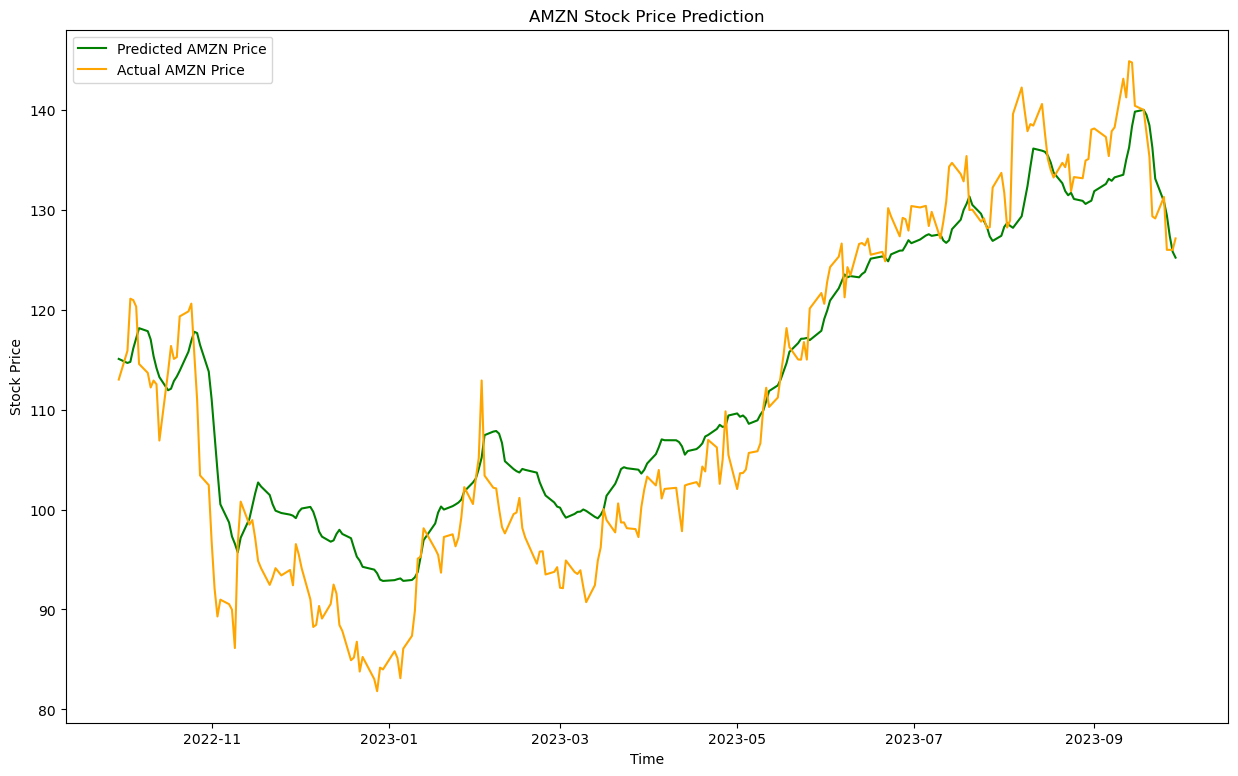

In [109]:
plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 1], color='green', label='Predicted AMZN Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 1], color='orange', label='Actual AMZN Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

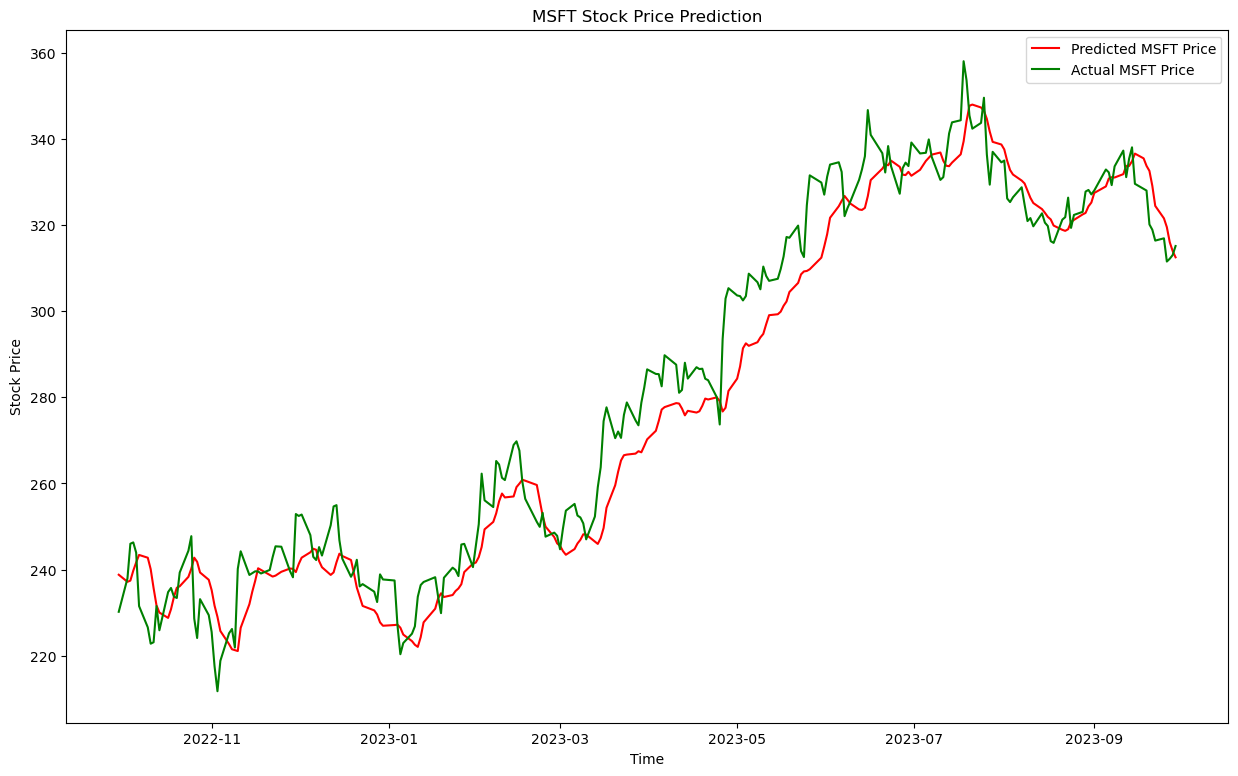

In [110]:
plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions[:, 2], color='red', label='Predicted MSFT Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y_test)[:, 2], color='green', label='Actual MSFT Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### LSTM Model Performance

In [111]:
## Show the test score of lstm model prediction
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

results_lstm = {}
aapl_mse = mean_squared_error(scaler.inverse_transform(y_test)[:, 0], actual_predictions[:, 0])
aapl_rmse = sqrt(aapl_mse)
aapl_mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test)[:, 0], actual_predictions[:, 0])
results_lstm[f'AAPL_LSTM'] = {'MSE': aapl_mse, 'RMSE': aapl_rmse, 'MAPE':aapl_mape}

amzn_mse = mean_squared_error(scaler.inverse_transform(y_test)[:, 1], actual_predictions[:, 1])
amzn_rmse = sqrt(amzn_mse)
amzn_mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test)[:, 1], actual_predictions[:, 1])
results_lstm[f'AMZN_LSTM'] = {'MSE': amzn_mse, 'RMSE': amzn_rmse, 'MAPE':amzn_mape}

msft_mse = mean_squared_error(scaler.inverse_transform(y_test)[:, 2], actual_predictions[:, 2])
msft_rmse = sqrt(msft_mse)
msft_mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test)[:, 2], actual_predictions[:, 2])
results_lstm[f'MSFT_LSTM'] = {'MSE': msft_mse, 'RMSE': msft_rmse, 'MAPE':msft_mape}

results_lstm_df = pd.DataFrame(results_lstm).T
print(results_lstm_df)

                 MSE      RMSE      MAPE
AAPL_LSTM  24.413140  4.940966  0.024695
AMZN_LSTM  30.833746  5.552814  0.044174
MSFT_LSTM  79.595687  8.921641  0.025726


## Transformer Model Training

In [79]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
    """
    Creates a single transformer block.
    """
    # Multi-Head Self-Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs  # Residual Connection

    # Feed Forward Part
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res  # Residual Connection

def build_transformer(head_size, num_heads, ff_dim,
                      num_trans_blocks, mlp_units,
                      dropout=0, mlp_dropout=0) -> tf.keras.Model:
    """
    Creates the final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 1
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs

    # Multiple Transformer Blocks
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling and MLP Head
    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)

    outputs = tf.keras.layers.Dense(n_outputs, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

In [80]:
# Build and Compile the Transformer Model
transformer = build_transformer(head_size=128, num_heads=4, ff_dim=2,
                                num_trans_blocks=4, mlp_units=[256],
                                mlp_dropout=0.10, dropout=0.10)

transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'],
)

# Training with Early Stopping Callback
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,
                                              restore_best_weights=True)]

#t_hist = transformer.fit(X_train, y_train, batch_size=32,
#                         epochs=25, validation_data=(X_test, y_test),
#                         verbose=1, callbacks=callbacks)

Visualization

In [84]:
### AAPL
stock_df = stock_data['Adj Close']
apple = stock_df['AAPL']
apple_df = apple.to_frame().reset_index()
apple_df.columns = ['Date', 'Adj Close']
apple_set = apple_df['Adj Close']

scaler = MinMaxScaler()
apple_set_scaled = scaler.fit_transform(apple_set.values.reshape(-1, 1))
X2, y2 = create_sequences(apple_set_scaled, SEQUENCE_LENGTH)

train_size= int(0.8 * len(X2))
X2_train = X2[:train_size]
y2_train = y2[:train_size]
X2_test = X2[train_size:]
y2_test = y2[train_size:]

t_hist = transformer.fit(X2_train, y2_train, batch_size=32,
                         epochs=25, validation_data=(X2_test, y2_test),
                         verbose=1, callbacks=callbacks)

Epoch 1/25
32/32 [==============================] - 0s 11ms/step - loss: 5.6404e-04 - mae: 0.0171 - mape: 29486.7266 - val_loss: 4.5412e-04 - val_mae: 0.0174 - val_mape: 2.2408
Epoch 2/25
32/32 [==============================] - 0s 10ms/step - loss: 5.5463e-04 - mae: 0.0170 - mape: 20884.2715 - val_loss: 4.1350e-04 - val_mae: 0.0154 - val_mape: 2.0761
Epoch 3/25
32/32 [==============================] - 0s 10ms/step - loss: 5.5000e-04 - mae: 0.0172 - mape: 27757.2695 - val_loss: 5.4830e-04 - val_mae: 0.0195 - val_mape: 2.4881
Epoch 4/25
32/32 [==============================] - 0s 10ms/step - loss: 4.5547e-04 - mae: 0.0153 - mape: 23959.9199 - val_loss: 3.0768e-04 - val_mae: 0.0134 - val_mape: 1.7820
Epoch 5/25
32/32 [==============================] - 0s 10ms/step - loss: 4.8083e-04 - mae: 0.0158 - mape: 27421.8457 - val_loss: 3.7591e-04 - val_mae: 0.0146 - val_mape: 1.9617
Epoch 6/25
32/32 [==============================] - 0s 10ms/step - loss: 6.0150e-04 - mae: 0.0174 - mape: 25090.669

8/8 [==============================] - 0s 4ms/step


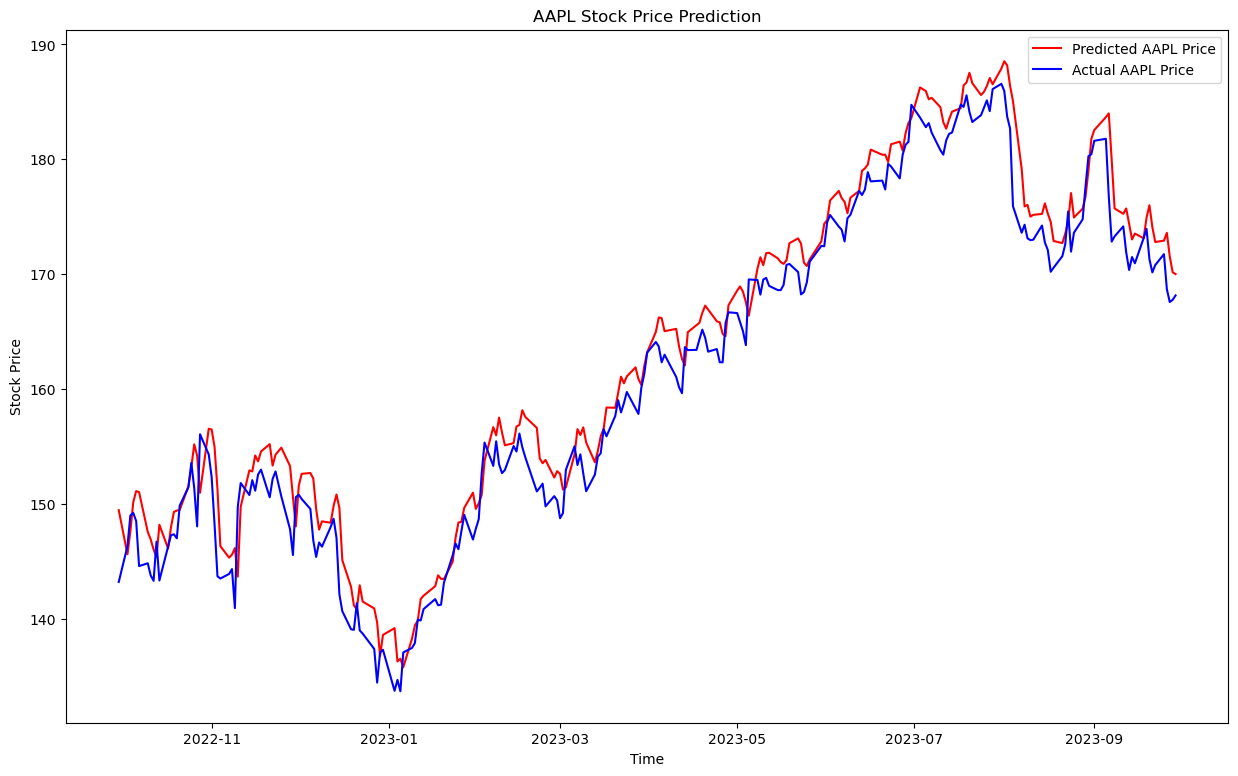

In [91]:
predicted_stock_price_2 = transformer.predict(X2_test)
actual_predictions_2 = scaler.inverse_transform(predicted_stock_price_2)
results_transformer = {}
aapl_mse_2 = mean_squared_error(scaler.inverse_transform(y2_test), actual_predictions_2)
aapl_rmse_2 = sqrt(aapl_mse_2)
aapl_mape_2 = mean_absolute_percentage_error(scaler.inverse_transform(y2_test), actual_predictions_2)
results_transformer[f'AAPL_TRAN'] = {'MSE': aapl_mse_2, 'RMSE': aapl_rmse_2, 'MAPE':aapl_mape_2}

plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions_2, color='red', label='Predicted AAPL Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y2_test), color='blue', label='Actual AAPL Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [92]:
### AMZN
amazon = stock_df['AMZN']
amazon_df = amazon.to_frame().reset_index()
amazon_df.columns = ['Date', 'Adj Close']
amazon_set = amazon_df['Adj Close']

scaler = MinMaxScaler()
amazon_set_scaled = scaler.fit_transform(amazon_set.values.reshape(-1, 1))
X3, y3 = create_sequences(amazon_set_scaled, SEQUENCE_LENGTH)

train_size= int(0.8 * len(X3))
X3_train = X3[:train_size]
y3_train = y3[:train_size]
X3_test = X3[train_size:]
y3_test = y3[train_size:]

t_hist = transformer.fit(X3_train, y3_train, batch_size=32,
                         epochs=25, validation_data=(X3_test, y3_test),
                         verbose=1, callbacks=callbacks)


Epoch 1/25
32/32 [==============================] - 0s 10ms/step - loss: 9.9811e-04 - mae: 0.0231 - mape: 29842.9492 - val_loss: 6.1023e-04 - val_mae: 0.0190 - val_mape: 5.8990
Epoch 2/25
32/32 [==============================] - 0s 10ms/step - loss: 9.7733e-04 - mae: 0.0231 - mape: 34334.9609 - val_loss: 5.0746e-04 - val_mae: 0.0169 - val_mape: 5.2995
Epoch 3/25
32/32 [==============================] - 0s 10ms/step - loss: 0.0011 - mae: 0.0248 - mape: 40473.0352 - val_loss: 5.1997e-04 - val_mae: 0.0173 - val_mape: 5.5153
Epoch 4/25
32/32 [==============================] - 0s 9ms/step - loss: 8.7404e-04 - mae: 0.0212 - mape: 28828.2500 - val_loss: 5.1448e-04 - val_mae: 0.0172 - val_mape: 5.4483
Epoch 5/25
32/32 [==============================] - 0s 10ms/step - loss: 9.1712e-04 - mae: 0.0225 - mape: 37794.2109 - val_loss: 5.0757e-04 - val_mae: 0.0168 - val_mape: 5.3038
Epoch 6/25
32/32 [==============================] - 0s 10ms/step - loss: 9.1313e-04 - mae: 0.0220 - mape: 21913.5332 - v

8/8 [==============================] - 0s 3ms/step


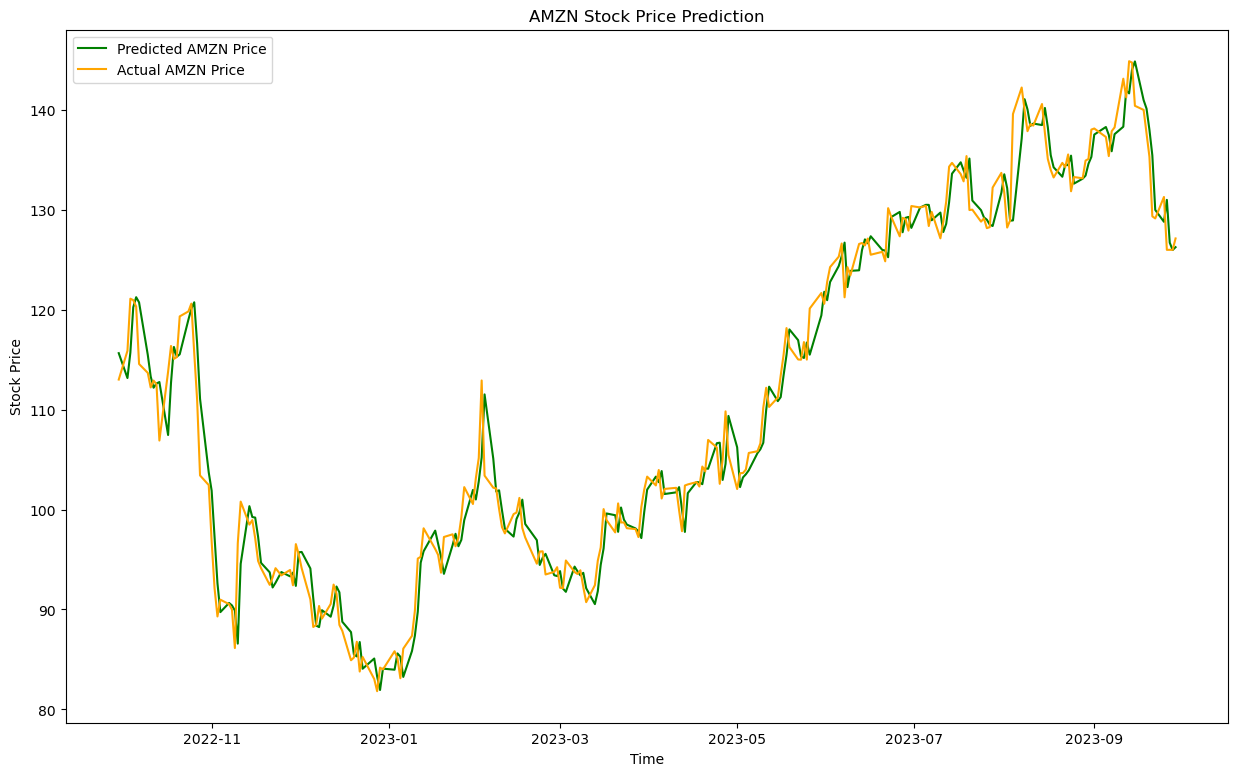

In [94]:
predicted_stock_price_3 = transformer.predict(X3_test)
actual_predictions_3 = scaler.inverse_transform(predicted_stock_price_3)
amzn_mse_2 = mean_squared_error(scaler.inverse_transform(y3_test), actual_predictions_3)
amzn_rmse_2 = sqrt(amzn_mse_2)
amzn_mape_2 = mean_absolute_percentage_error(scaler.inverse_transform(y3_test), actual_predictions_3)
results_transformer[f'AMZN_TRAN'] = {'MSE': amzn_mse_2, 'RMSE': amzn_rmse_2, 'MAPE':amzn_mape_2}

plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions_3, color='green', label='Predicted AMZN Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y3_test), color='orange', label='Actual AMZN Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [95]:
##MSFT
microsoft = stock_df['MSFT']
microsoft_df = microsoft.to_frame().reset_index()
microsoft_df.columns = ['Date', 'Adj Close']
microsoft_set = microsoft_df['Adj Close']

scaler = MinMaxScaler()
microsoft_set_scaled = scaler.fit_transform(microsoft_set.values.reshape(-1, 1))
X4, y4 = create_sequences(microsoft_set_scaled, SEQUENCE_LENGTH)

train_size= int(0.8 * len(X4))
X4_train = X4[:train_size]
y4_train = y4[:train_size]
X4_test = X4[train_size:]
y4_test = y4[train_size:]

t_hist = transformer.fit(X4_train, y4_train, batch_size=32,
                         epochs=25, validation_data=(X4_test, y4_test),
                         verbose=1, callbacks=callbacks)

Epoch 1/25
32/32 [==============================] - 0s 10ms/step - loss: 5.0451e-04 - mae: 0.0162 - mape: 36153.8047 - val_loss: 3.9727e-04 - val_mae: 0.0157 - val_mape: 2.3424
Epoch 2/25
32/32 [==============================] - 0s 10ms/step - loss: 4.5507e-04 - mae: 0.0155 - mape: 24380.7637 - val_loss: 6.3976e-04 - val_mae: 0.0203 - val_mape: 2.8736
Epoch 3/25
32/32 [==============================] - 0s 10ms/step - loss: 3.9172e-04 - mae: 0.0144 - mape: 36442.9453 - val_loss: 5.5156e-04 - val_mae: 0.0185 - val_mape: 2.6771
Epoch 4/25
32/32 [==============================] - 0s 9ms/step - loss: 4.5212e-04 - mae: 0.0155 - mape: 24692.6504 - val_loss: 4.0863e-04 - val_mae: 0.0159 - val_mape: 2.3820
Epoch 5/25
32/32 [==============================] - 0s 9ms/step - loss: 4.3277e-04 - mae: 0.0150 - mape: 29964.9648 - val_loss: 4.1503e-04 - val_mae: 0.0161 - val_mape: 2.4006
Epoch 6/25
32/32 [==============================] - 0s 9ms/step - loss: 4.2093e-04 - mae: 0.0145 - mape: 18110.2812 -

8/8 [==============================] - 0s 3ms/step


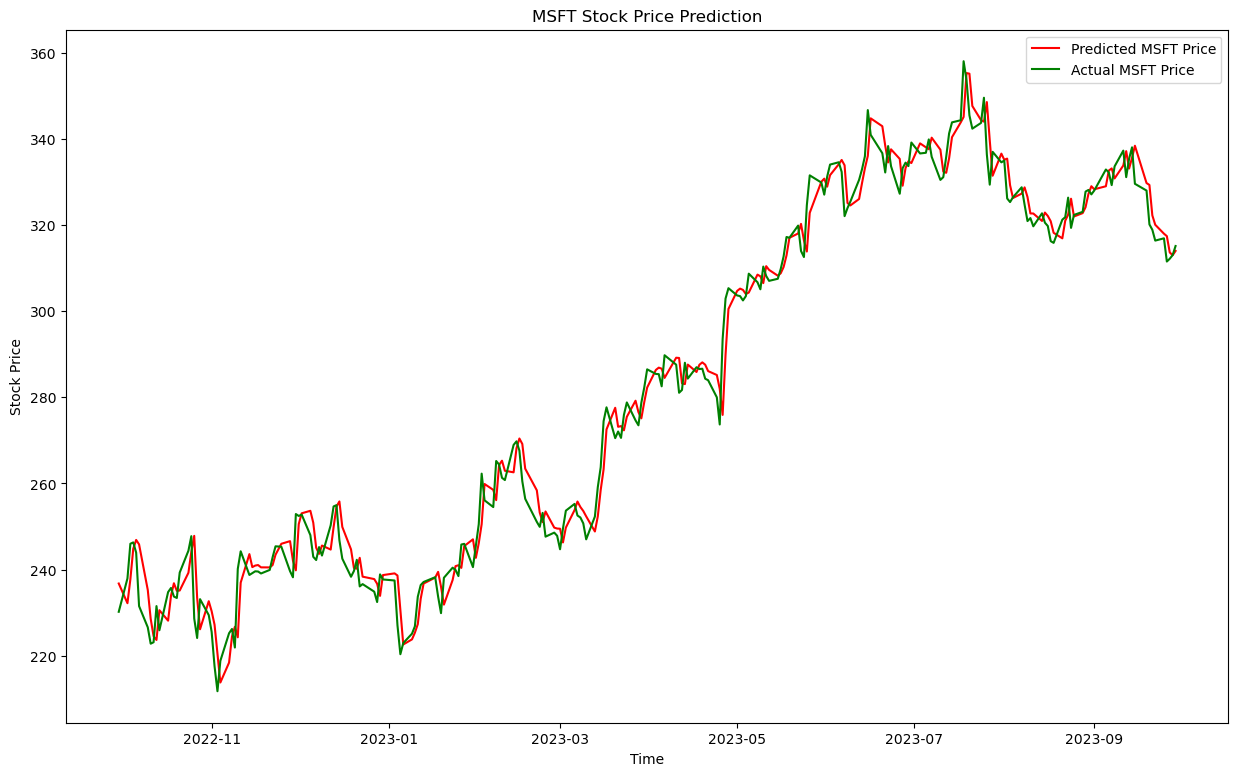

In [96]:
predicted_stock_price_4 = transformer.predict(X4_test)
actual_predictions_4 = scaler.inverse_transform(predicted_stock_price_4)
msft_mse_2 = mean_squared_error(scaler.inverse_transform(y4_test), actual_predictions_4)
msft_rmse_2 = sqrt(msft_mse_2)
msft_mape_2 = mean_absolute_percentage_error(scaler.inverse_transform(y4_test), actual_predictions_4)
results_transformer[f'MSFT_TRAN'] = {'MSE': msft_mse_2, 'RMSE': msft_rmse_2, 'MAPE':msft_mape_2}

plt.figure(figsize=(15,9))
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], actual_predictions_4, color='red', label='Predicted MSFT Price')
plt.plot(stock_data.index[train_size+SEQUENCE_LENGTH:], scaler.inverse_transform(y4_test), color='green', label='Actual MSFT Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### Transformer Model Performance

In [97]:
results_transformer_df = pd.DataFrame(results_transformer).T
print(results_transformer_df)

                 MSE      RMSE      MAPE
AAPL_TRAN   8.376897  2.894287  0.015027
AMZN_TRAN   7.049429  2.655076  0.018220
MSFT_TRAN  28.431396  5.332110  0.015315
